In this notebook, I implement a sentiment classification pipeline using book review data. The goal is to predict whether a review is positive using natural language processing and a feedforward neural network. The key steps include data preprocessing, feature extraction using TF-IDF, model training, and evaluation.

In [40]:
import pandas as pd
import numpy as np
import os 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # suppress info and warning messages
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import time 

In [41]:
df = pd.read_csv("bookReviews.csv")

In [42]:
print("# of rows: " + str(df.shape[0]))
print("# of columns: " + str(df.shape[1]))
print("first ten rows: ")
df.head()

# of rows: 1973
# of columns: 2
first ten rows: 


,Review,Positive Review
0,This was perhaps the best of Johannes Steinhof...,True
1,This very fascinating book is a story written ...,True
2,The four tales in this collection are beautifu...,True
3,The book contained more profanity than I expec...,False
4,We have now entered a second time of deep conc...,True


When looking at the head, we can see the dataset contains a text column labeled “Review” and a binary label column “Positive Review”. This matches the expected format for binary classification.


In [43]:
y = df['Positive Review']
X = df['Review']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
X_train.shape

(1479,)

We split the data into features X (text reviews) and labels y (binary sentiment: 1 = positive, 0 = negative). Then, we create a 75/25 train-test split. A stratified split could be considered if class imbalance is suspected.

In [45]:
# 1. Create a TfidfVectorizer object 
#tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1, 2))

# 2. Fit the vectorizer to X_train
tfidf_vectorizer.fit(X_train)

# 3. Using the fitted vectorizer, transform the training data 
X_train_tfidf = tfidf_vectorizer.transform(X_train)


# 4. Using the fitted vectorizer, transform the test data 
X_test_tfidf = tfidf_vectorizer.transform(X_test)

TF-IDF (Term Frequency–Inverse Document Frequency) converts text into numerical features, preserving information on word frequency while down-weighting common words.
- min_df=5: Filters out infrequent terms (words appearing in fewer than 5 documents).
- ngram_range=(1, 2): Uses both unigrams and bigrams, which can help capture short phrases like “not good” or “very bad”.

In [46]:
vocabulary_size = len(tfidf_vectorizer.vocabulary_)

print(vocabulary_size)

8834


A large vocabulary size could indicate diverse language, while a very small one might reflect overly strict min_df or limited dataset size.

In [47]:
# 1. Create model object
nn_model = keras.Sequential()

# 2. Create the input layer and add it to the model object: 
input_shape = (vocabulary_size,)  # Replace vocabulary_size with your actual vocabulary size
nn_model.add(keras.layers.InputLayer(input_shape=input_shape))


# 3. Create the first hidden layer and add it to the model object:
nn_model.add(keras.layers.Dense(units=64, activation='relu'))


# 4. Create the second layer and add it to the model object:
nn_model.add(keras.layers.Dense(units=32, activation='relu'))


# 5. Create the third layer and add it to the model object:
nn_model.add(keras.layers.Dense(units=16, activation='relu'))


# 6. Create the output layer and add it to the model object:
nn_model.add(keras.layers.Dense(units=1, activation='sigmoid'))


# Print summary of neural network model structure
nn_model.summary()

/Users/izabelladoser/Desktop/jupyter_projects/venv/lib/python3.13/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_144 (Dense)               │ (None, 64)             │       565,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 568,065 (2.17 MB)

 Trainable params: 568,065 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

We define a simple fully connected (feedforward) neural network:
- Input Layer: Based on the number of TF-IDF features.
- Hidden Layers: 3 layers with ReLU activation for non-linearity.
- Output Layer: 1 neuron with Sigmoid activation for binary classification.
  
This architecture is intentionally lightweight to ensure it trains quickly and avoids overfitting, given the relatively small dataset.

In [48]:
sgd_optimizer = keras.optimizers.SGD(learning_rate=0.1)

In [49]:
loss_fn = keras.losses.BinaryCrossentropy(from_logits = False)

In [50]:
nn_model.compile(optimizer=sgd_optimizer, loss=loss_fn, metrics=['accuracy'])

In [51]:
class ProgBarLoggerNEpochs(keras.callbacks.Callback):
    
    def __init__(self, num_epochs: int, every_n: int = 50):
        self.num_epochs = num_epochs
        self.every_n = every_n
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every_n == 0:
            s = 'Epoch [{}/ {}]'.format(epoch + 1, self.num_epochs)
            logs_s = ['{}: {:.4f}'.format(k.capitalize(), v)
                      for k, v in logs.items()]
            s_list = [s] + logs_s
            print(', '.join(s_list))

In [52]:
t0 = time.time() # start time

num_epochs = 55

history = nn_model.fit( X_train_tfidf.toarray(), y_train, epochs=num_epochs, verbose=0, validation_split=0.2, callbacks=[ProgBarLoggerNEpochs(num_epochs, every_n=5)])
t1 = time.time() # stop time

print('Elapsed time: %.2fs' % (t1-t0))


Epoch [5/ 55], Accuracy: 0.6027, Loss: 0.6863, Val_accuracy: 0.4797, Val_loss: 0.6898
Epoch [10/ 55], Accuracy: 0.7802, Loss: 0.6293, Val_accuracy: 0.4696, Val_loss: 0.7106
Epoch [15/ 55], Accuracy: 0.7210, Loss: 0.5109, Val_accuracy: 0.5541, Val_loss: 0.6946
Epoch [20/ 55], Accuracy: 0.8521, Loss: 0.3246, Val_accuracy: 0.6182, Val_loss: 0.7824
Epoch [25/ 55], Accuracy: 0.9366, Loss: 0.1982, Val_accuracy: 0.7973, Val_loss: 0.4298
Epoch [30/ 55], Accuracy: 0.9992, Loss: 0.0205, Val_accuracy: 0.8007, Val_loss: 0.4972
Epoch [35/ 55], Accuracy: 1.0000, Loss: 0.0060, Val_accuracy: 0.8041, Val_loss: 0.5492
Epoch [40/ 55], Accuracy: 1.0000, Loss: 0.0032, Val_accuracy: 0.8041, Val_loss: 0.5870
Epoch [45/ 55], Accuracy: 1.0000, Loss: 0.0021, Val_accuracy: 0.8041, Val_loss: 0.6145
Epoch [50/ 55], Accuracy: 1.0000, Loss: 0.0015, Val_accuracy: 0.8074, Val_loss: 0.6344
Epoch [55/ 55], Accuracy: 1.0000, Loss: 0.0011, Val_accuracy: 0.8007, Val_loss: 0.6560
Elapsed time: 5.80s


In this section, we train a binary classification neural network using stochastic gradient descent (SGD) with a learning rate of 0.1 and the binary crossentropy loss function.

We implemented a custom callback class ProgBarLoggerNEpochs to print training progress every 5 epochs. This allows us to monitor model accuracy and loss trends during training without cluttering the output.

The model was trained for 55 epochs on a TF-IDF vectorized dataset, with 20% of the data held out for validation.

--------------------------------------------------------------------------------------
Observations:
- Training Accuracy quickly reached 100% within 30 epochs.
- Validation Accuracy plateaued around ~0.79 after epoch 20.
- Validation Loss initially decreased but then fluctuated slightly (e.g., increased at epoch 50 and 55).

This suggests that the model may be overfitting to the training data, the accuracy on the training set keeps improving, but the performance on the validation set does not show the same trend.


In [53]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

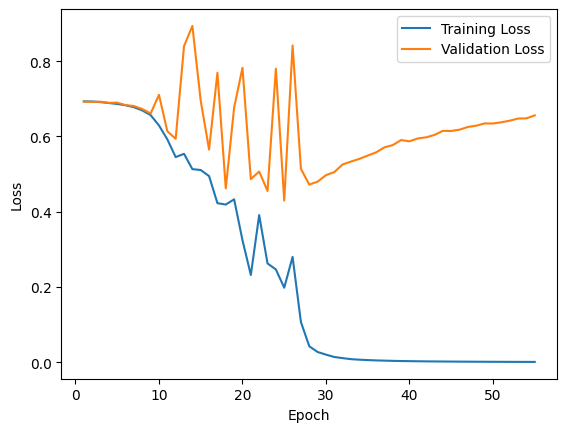

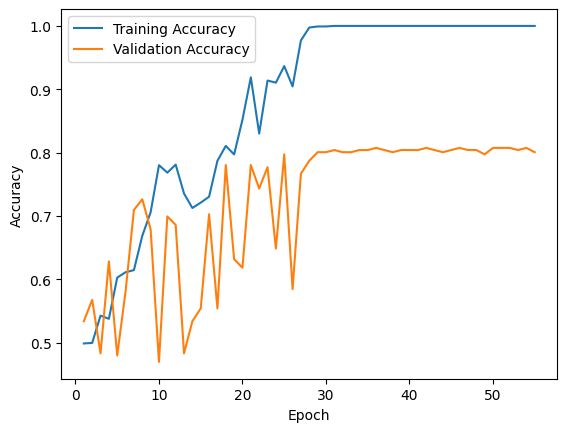

In [54]:
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Plot training and validation accuracy
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


###  Observations from Training and Validation Metrics 

After training the neural network for 100 epochs, the plots show clear trends in both accuracy and loss:

- Training Accuracy climbs to 100%, meaning the model fits the training data very well.
- Training Loss steadily decreases and flattens near zero.
- Validation Accuracy plateaus around 79–80% and starts fluctuating after a point.
- Validation Loss initially decreases but later increases and becomes erratic.


###  Signs of Overfitting

These trends suggest the model is overfitting:

- It performs extremely well on the training set but doesn't generalize to unseen data.
- The gap between training and validation accuracy becomes wide.
- The increase in validation loss while training loss continues to drop is a key signal of overfitting.

### Suggestions for Improvement

To combat overfitting and improve validation performance:

- Apply regularization techniques such as Dropout, L2 regularization, or EarlyStopping.
- Simplify the model by reducing the number of hidden layers or neurons.
- Collect or generate more training data to provide the model with more generalizable patterns.
- Use data augmentation (if applicable) to increase data diversity.
- Consider using early stopping to halt training when validation performance starts degrading.
---


Epoch [5/ 10], Accuracy: 0.6095, Loss: 0.6820, Val_accuracy: 0.6892, Val_loss: 0.6814
Epoch [10/ 10], Accuracy: 0.7422, Loss: 0.5604, Val_accuracy: 0.5304, Val_loss: 0.8081
Elapsed time for 10 epochs: 1.36s
--------------------------------------------------
Epoch [5/ 30], Accuracy: 0.6019, Loss: 0.6864, Val_accuracy: 0.5304, Val_loss: 0.6875
Epoch [10/ 30], Accuracy: 0.7828, Loss: 0.6176, Val_accuracy: 0.5574, Val_loss: 0.6438
Epoch [15/ 30], Accuracy: 0.7396, Loss: 0.5085, Val_accuracy: 0.7500, Val_loss: 0.5025
Epoch [20/ 30], Accuracy: 0.8352, Loss: 0.3499, Val_accuracy: 0.5101, Val_loss: 1.2445
Epoch [25/ 30], Accuracy: 0.8952, Loss: 0.2816, Val_accuracy: 0.5338, Val_loss: 1.0530
Epoch [30/ 30], Accuracy: 1.0000, Loss: 0.0143, Val_accuracy: 0.8176, Val_loss: 0.5181
Elapsed time for 30 epochs: 3.21s
--------------------------------------------------
Epoch [5/ 50], Accuracy: 0.5866, Loss: 0.6858, Val_accuracy: 0.6520, Val_loss: 0.6866
Epoch [10/ 50], Accuracy: 0.7396, Loss: 0.6053, Va

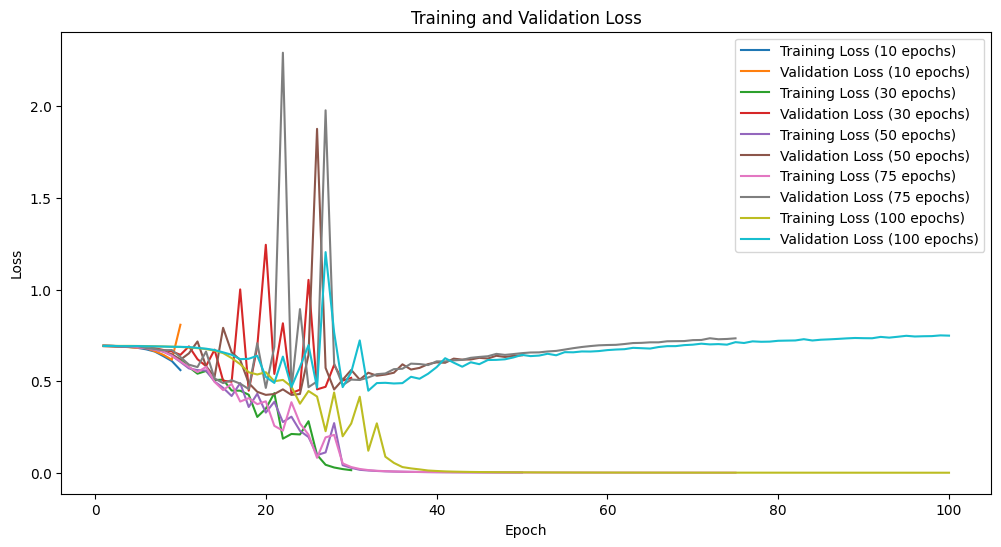

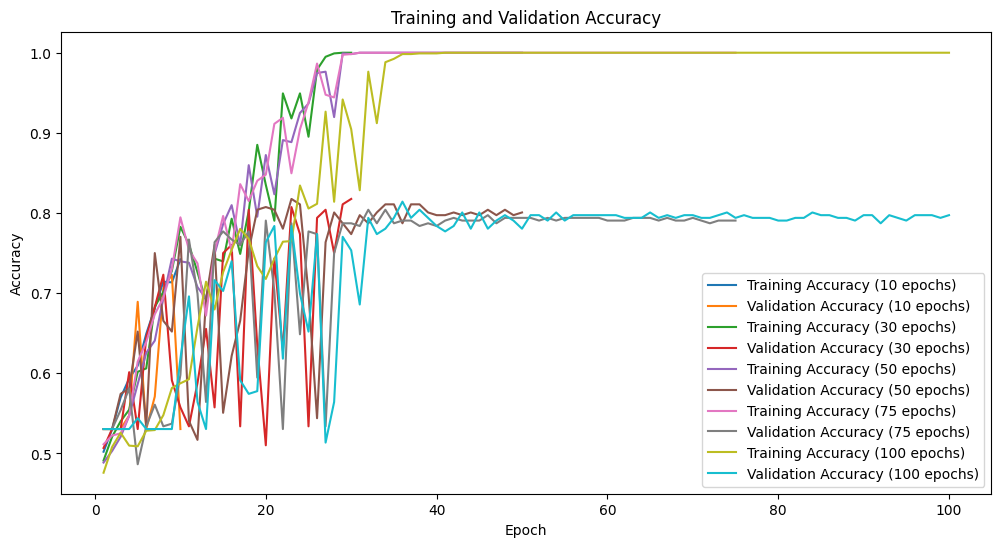

In [55]:
def testing_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    model.add(keras.layers.Dense(units=64, activation='relu'))
    model.add(keras.layers.Dense(units=32, activation='relu'))
    model.add(keras.layers.Dense(units=16, activation='relu'))
    model.add(keras.layers.Dense(units=1, activation='sigmoid'))
    return model

epoch_values = [10, 30, 50, 75, 100]

history_dict = {}


# Loop through each epoch value
for num_epochs in epoch_values:
    nn_model = testing_model(input_shape=(vocabulary_size,))  
    
    sgd_optimizer = keras.optimizers.SGD(learning_rate=0.1)
    loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
    nn_model.compile(optimizer=sgd_optimizer, loss=loss_fn, metrics=['accuracy'])
  
    t0 = time.time()  
    history = nn_model.fit(X_train_tfidf.toarray(), y_train, epochs=num_epochs, verbose=0, validation_split=0.2, callbacks=[ProgBarLoggerNEpochs(num_epochs, every_n=5)])
    t1 = time.time()  

    history_dict[num_epochs] = history
    
    print(f'Elapsed time for {num_epochs} epochs: %.2fs' % (t1-t0))
    
    print("-" * 50)

plt.figure(figsize=(12, 6))
for num_epochs, hist in history_dict.items():
    plt.plot(range(1, num_epochs + 1), hist.history['loss'], label=f'Training Loss ({num_epochs} epochs)')
    plt.plot(range(1, num_epochs + 1), hist.history['val_loss'], label=f'Validation Loss ({num_epochs} epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(12, 6))
for num_epochs, hist in history_dict.items():
    plt.plot(range(1, num_epochs + 1), hist.history['accuracy'], label=f'Training Accuracy ({num_epochs} epochs)')
    plt.plot(range(1, num_epochs + 1), hist.history['val_accuracy'], label=f'Validation Accuracy ({num_epochs} epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

### Observations from Epoch Logs

- The training accuracy rapidly increases and reaches 100% by around epoch 30, indicating the model is learning the training data very well.
- However, the validation accuracy seems to plateau around ~79% and even fluctuates, which suggests some **overfitting**.
- Validation loss initially decreases but later increases slightly, another sign that the model may be memorizing the training data rather than generalizing.
- This behavior can be mitigated by regularization or early stopping in future iterations.

Epoch [5/ 10], Accuracy: 0.5621, Loss: 0.6870, Val_accuracy: 0.5304, Val_loss: 0.6852
Epoch [10/ 10], Accuracy: 0.6686, Loss: 0.6370, Val_accuracy: 0.7365, Val_loss: 0.6458
Elapsed time for 10 epochs: 1.45s
--------------------------------------------------
Epoch [5/ 30], Accuracy: 0.5216, Loss: 0.6918, Val_accuracy: 0.5304, Val_loss: 0.6910
Epoch [10/ 30], Accuracy: 0.5799, Loss: 0.6832, Val_accuracy: 0.6453, Val_loss: 0.6852
Epoch [15/ 30], Accuracy: 0.6982, Loss: 0.6318, Val_accuracy: 0.6250, Val_loss: 0.6431
Epoch [20/ 30], Accuracy: 0.7684, Loss: 0.5054, Val_accuracy: 0.6284, Val_loss: 0.6132
Epoch [25/ 30], Accuracy: 0.8512, Loss: 0.3811, Val_accuracy: 0.8007, Val_loss: 0.4529
Epoch [30/ 30], Accuracy: 0.8538, Loss: 0.3463, Val_accuracy: 0.7872, Val_loss: 0.4765
Elapsed time for 30 epochs: 3.27s
--------------------------------------------------
Epoch [5/ 50], Accuracy: 0.5782, Loss: 0.6812, Val_accuracy: 0.6824, Val_loss: 0.6820
Epoch [10/ 50], Accuracy: 0.7025, Loss: 0.6082, Va

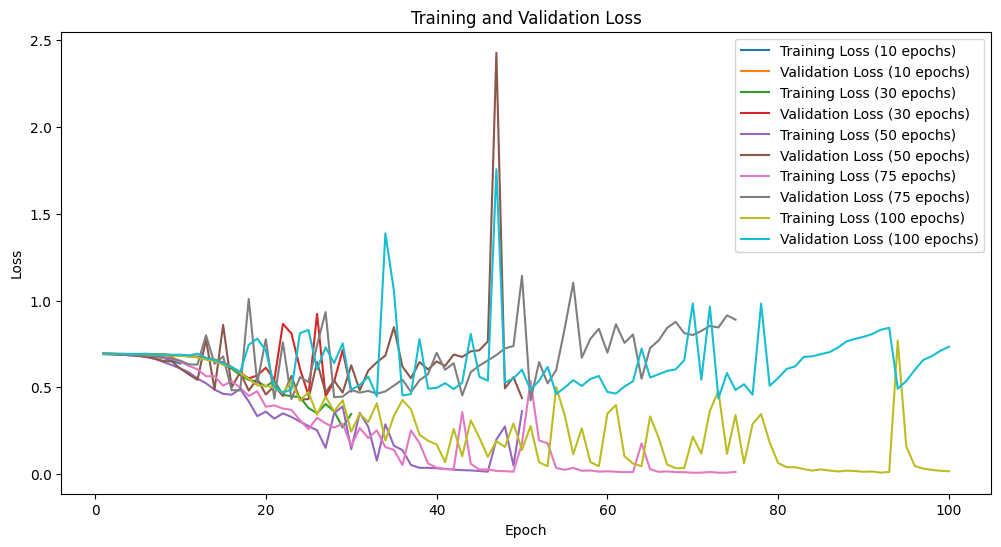

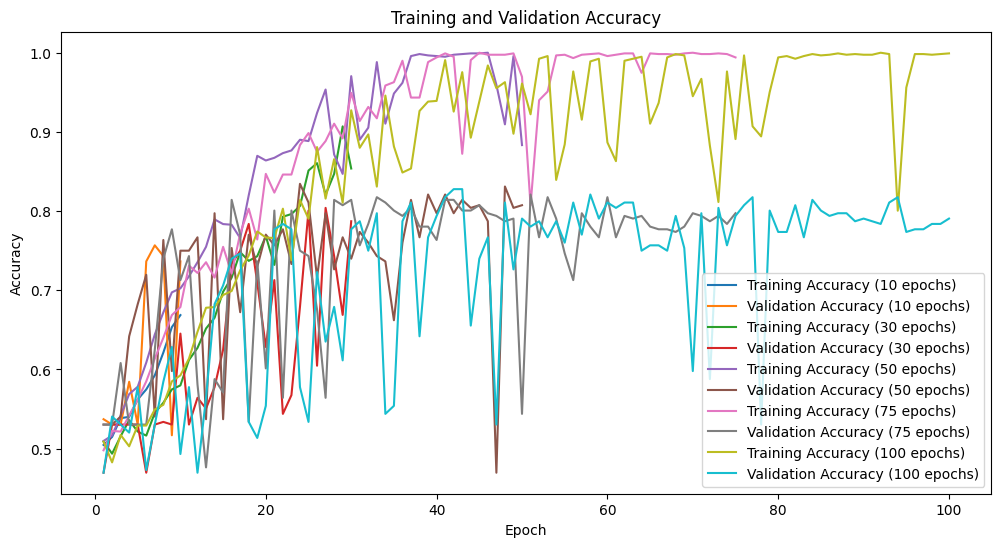

In [56]:
def testing_model_dropout(input_shape, dropout_rate=0.25):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    model.add(keras.layers.Dense(units=64, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(units=32, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(units=16, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(units=1, activation='sigmoid'))
    return model

epoch_values = [10, 30, 50, 75, 100]

history_dict = {}


# Loop through each epoch value
for num_epochs in epoch_values:
    nn_model = testing_model_dropout(input_shape=(vocabulary_size,))  
    
    sgd_optimizer = keras.optimizers.SGD(learning_rate=0.1)
    loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
    nn_model.compile(optimizer=sgd_optimizer, loss=loss_fn, metrics=['accuracy'])
  
    t0 = time.time()  
    history = nn_model.fit(X_train_tfidf.toarray(), y_train, epochs=num_epochs, verbose=0, validation_split=0.2, callbacks=[ProgBarLoggerNEpochs(num_epochs, every_n=5)])
    t1 = time.time()  

    history_dict[num_epochs] = history
    
    print(f'Elapsed time for {num_epochs} epochs: %.2fs' % (t1-t0))
    
    print("-" * 50)

plt.figure(figsize=(12, 6))
for num_epochs, hist in history_dict.items():
    plt.plot(range(1, num_epochs + 1), hist.history['loss'], label=f'Training Loss ({num_epochs} epochs)')
    plt.plot(range(1, num_epochs + 1), hist.history['val_loss'], label=f'Validation Loss ({num_epochs} epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(12, 6))
for num_epochs, hist in history_dict.items():
    plt.plot(range(1, num_epochs + 1), hist.history['accuracy'], label=f'Training Accuracy ({num_epochs} epochs)')
    plt.plot(range(1, num_epochs + 1), hist.history['val_accuracy'], label=f'Validation Accuracy ({num_epochs} epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

### Observations from the Graphs

Accuracy Plot:
- Training Accuracy (colored lines) steadily increases and saturates at nearly 100% for 50+ epochs.
- Validation Accuracy improves initially but becomes volatile and stops improving or dips after 30–50 epochs.
-  Indicates potential memorization of training data rather than learning general patterns.

Loss Plot:
- Training Loss consistently drops near 0 — which is expected.
- Validation Loss decreases up to a point but later spikes or fluctuates, especially beyond 30 epochs.
- Suggests that the model’s ability to generalize worsens with more training — a classic sign of overfitting.


### Interpretation

These results reveal a common pattern when using powerful models on limited or non-diverse data:
- The model fits the training data extremely well.
- However, dropout alone is not enough to counter overfitting in this case.
- Validation performance degrades due to:
- Lack of regularization beyond dropout.
- Potential lack of sufficient or diverse training data.

---


In [57]:
loss, accuracy = nn_model.evaluate(X_test_tfidf.toarray(), y_test)

print('Loss: ', str(loss) , 'Accuracy: ', str(accuracy))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8178 - loss: 0.5512
Loss:  0.5512040257453918 Accuracy:  0.8178137540817261


In [58]:
# Make predictions on the test set
probability_predictions = nn_model.predict(X_test_tfidf.toarray())

y_test_array = y_test.to_numpy()

print("Predictions for the first 20 examples:")

for i in range(20):
    probability = probability_predictions[i][0]  # Extract the scalar probability value
    label = y_test_array[i]
    
    if probability > 0.5:
        print(f"Probability: {probability:.4f}, Actual Label: {label}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Predictions for the first 20 examples:
Probability: 0.5849, Actual Label: True
Probability: 0.9990, Actual Label: True
Probability: 0.9996, Actual Label: True
Probability: 0.7029, Actual Label: False
Probability: 0.9979, Actual Label: True
Probability: 0.9168, Actual Label: True
Probability: 0.9990, Actual Label: True
Probability: 0.9999, Actual Label: True
Probability: 0.9999, Actual Label: True
Probability: 0.7586, Actual Label: False
Probability: 0.9996, Actual Label: True


### Prediction Analysis for First 20 Reviews
- The model prints out the predicted probability and the actual label for each review.
- A prediction is classified as “good” if the probability is greater than 0.5.
- From the output:
   - The model mostly aligns with the actual labels.
   - However, some predictions are confidently wrong, indicating overfitting or misinterpretation of sentiment due to ambiguous language or subtle cues in reviews.

In [59]:
print('Review #1:\n')

print(X_test.to_numpy()[11])

goodReview = True if probability_predictions[11] >= .5 else False
    
print('\nPrediction: Is this a good review? {}\n'.format(goodReview))

print('Actual: Is this a good review? {}\n'.format(y_test.to_numpy()[11]))

Review #1:

Over 20 years after it was published, the story of the Israeli attempt to eradicate massive and repeated terrorist attacks emanating from the PLO (Bubba's/Jacques/UN's buddy Yasser) in Lebanon is no less important.  Interestingly, Lebanon is still struggling to rid itself of Syrian occupation.  They have gone from the vegan dictator Hafez Assad murdering opponents and journalists to the Syrian optometrist dictator murdering opponents and journalists (another killed last week 7/2005).

In this review, I will attempt to explain the story, the left-wing/doves reporter's views (and on so many levels his mistakes), and most importantly to Americans who love and support Israel, the correlation between Israel's actions and our "War on Terror."

First to the journalists, the main one being the left wing newspaper Haraatz Ze'ev Schiff.  As the brilliant reviewer givbatam3 points out nearby, Mr. Schiff is a member of the Israeli left/dove/Peace Now group.  This "coalition" consists o

In [60]:
print('Review #2:\n')

print(X_test.to_numpy()[24])

goodReview = True if probability_predictions[24] >= .5 else False

print('\nPrediction: Is this a good review? {}\n'.format(goodReview)) 

print('Actual: Is this a good review? {}\n'.format(y_test.to_numpy()[24]))

Review #2:

I have many robot books and this is the best and most informative book of all. It is easy to understand and read; I personally couldn't put it down. I wish it was twice as long while still marinating the high info density... Most authors just babble and every few pages actually tell you something; this is not the case with this book! 

The programming of a robot is everything... and behavior based programming is the only way to go. This book provides a very good intro into that very subject. The only complaint I have is not about the book but his robot simulation program on is website which is referred to in the text. It seems to be rather slow and over taxing for the PC, but being a Java app it's not that surprising.

Highly recommended to anyone building robots


Prediction: Is this a good review? True

Actual: Is this a good review? True



In [61]:
print('Review #3:\n')

print(X_test.to_numpy()[56])

goodReview = True if probability_predictions[56] >= .5 else False
    
print('\nPrediction: Is this a good review? {}\n'.format(goodReview))

print('Actual: Is this a good review? {}\n'.format(y_test.to_numpy()[56]))

Review #3:

This is a very popular book, which is sad because it's highly biased. She provides evidence, but only uses the 10th that corroborates her story.

Christian study maybe, Christian fact, VERY loosely


Prediction: Is this a good review? False

Actual: Is this a good review? False



In [62]:
print('Review #4:\n')
print(X_test.to_numpy()[102])

goodReview = True if probability_predictions[102] >= .5 else False
    
print('\nPrediction: Is this a good review? {}\n'.format(goodReview))

print('Actual: Is this a good review? {}\n'.format(y_test.to_numpy()[102]))

Review #4:

There were so many continuity errors and spelling problems in this book that I had to stop. Trying to follow two-dimensional characters are difficult enough.  I was just looking for a good fiction book that contained gay themes, characters or both.  I got the gay but not the story


Prediction: Is this a good review? False

Actual: Is this a good review? False

